In [5]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt

import time

def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.

    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a
    # hyperparameter.

    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)

    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)

        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                             1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                             np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))

    def forward_with_intermediate(self, input):
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate


class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False,
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()

        self.net = []
        self.net.append(SineLayer(in_features, hidden_features,
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features,
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)

            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0,
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)

            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features,
                                      is_first=False, omega_0=hidden_omega_0))

        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)

                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()

                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else:
                x = layer(x)

                if retain_grad:
                    x.retain_grad()

            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

And finally, differential operators that allow us to leverage autograd to compute gradients, the laplacian, etc.

In [43]:
def laplace(y, x):
    grad = gradient(y, x)
    return divergence(grad, x)

def divergence(y, x):
    div = 0.
    print("div",y.shape,x.shape)
    for i in range(y.shape[-1]):
        div += torch.autograd.grad(y[..., i], x, torch.ones_like(y[..., i]), create_graph=True,allow_unused=True)[0][..., i:i+1]
    return div


def gradient(y, x, grad_outputs=None):

    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True,allow_unused=True)[0]
    print("grad",y.shape,x.shape)
    print(grad)
    return grad

In [8]:
def get_cameraman_tensor(sidelength):
    img = Image.fromarray(skimage.data.camera())
    transform = Compose([
        Resize(sidelength),
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
    img = transform(img)
    return img



def get_meerkat_image(sidelength):
  from astropy.io import fits
  import numpy as np
  filename = "/content/drive/MyDrive/Colab Notebooks/MeerKAT_Galactic_Centre_1284MHz-StokesI.fits"
  with fits.open(filename) as hdul:
      data = hdul[0].data[4500:4500+sidelength,4500:4500+sidelength].astype(np.float32)
  data = data-np.min(data)
  data+=1e-5
  data=np.log(data)
  data = data-np.min(data)
  data = data/np.max(data)
  img =  Image.fromarray(data)
  del data
  transform = Compose([
      Resize(sidelength),
      ToTensor(),
      Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
  ])
  img = transform(img)
  return img

In [107]:
class ImageFitting(Dataset):
    def __init__(self, sidelength, pixels_per_iter = 256**2):
        super().__init__()
        #img = get_cameraman_tensor(sidelength)
        img = get_meerkat_image(sidelength)
        self.sidelength = sidelength
        self.pixels = img.permute(1, 2, 0).view(-1, 1)
        self.coords       = get_mgrid(sidelength, 2)
        self.N_pixels_per_iter = pixels_per_iter
        self.N_total_pixels = sidelength**2

    def __len__(self):
        return 1

    def get_coords(self):
        return self.coords

    def get_sparse_coords(self,sparsesidelength):
        assert self.sidelength%sparsesidelength==0
        return get_mgrid(sparsesidelength, 2)

    def get_sparse_pixels(self,sparse_coords):
        assert self.pixels.shape[0]%sparse_coords.shape[0]==0
        f = int(np.sqrt(int(self.pixels.shape[0]/sparse_coords.shape[0])))
        pixels = self.pixels.reshape(self.sidelength,self.sidelength,1)
        sparse_pixels = pixels[::f,::f,:].reshape(-1,1)
        assert sparse_pixels.shape[0] == sparse_coords.shape[0]
        return sparse_pixels

    def get_pixels(self):
        return self.pixels

    def __getitem__(self, idx):
        if idx > 0: raise IndexError
        # choose random N_pixels_per_iter out of N_total_pixels
        idx = np.random.choice(self.N_total_pixels, self.N_pixels_per_iter,replace=False)
        pixels = self.pixels[idx,:]
        coords = self.coords[idx,:]

        return coords, pixels


In [108]:
sidelength = 256*2
milkyway = ImageFitting(sidelength)
dataloader = DataLoader(milkyway, batch_size=1, pin_memory=True, num_workers=0)

img_siren = Siren(in_features=2, out_features=1, hidden_features=256,
                  hidden_layers=3, outermost_linear=True)
img_siren.cuda()

Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

We now fit Siren in a simple training loop. Within only hundreds of iterations, the image and its gradients are approximated well.

torch.Size([65536, 1]) torch.Size([65536, 2])
Step 0, Total loss 0.001189


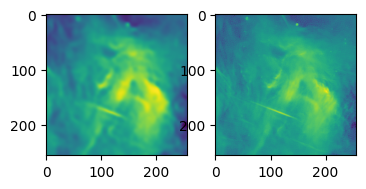

Step 10, Total loss 0.002451


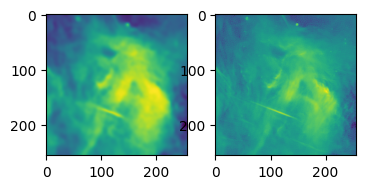

Step 20, Total loss 0.001519


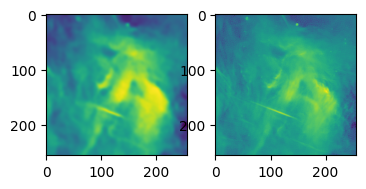

Step 30, Total loss 0.001219


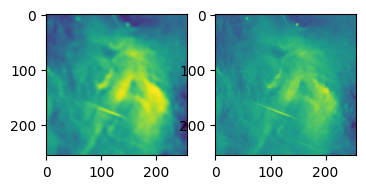

Step 40, Total loss 0.001139


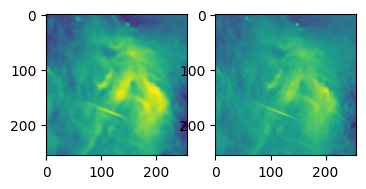

Step 50, Total loss 0.001045


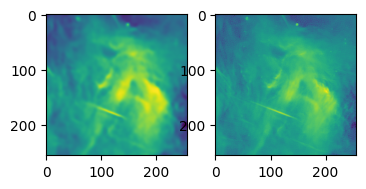

Step 60, Total loss 0.001008


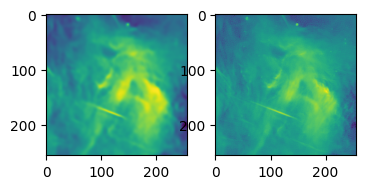

Step 70, Total loss 0.000992


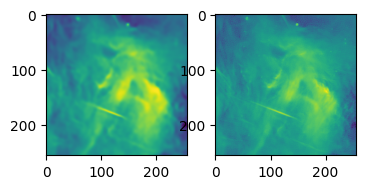

Step 80, Total loss 0.000970


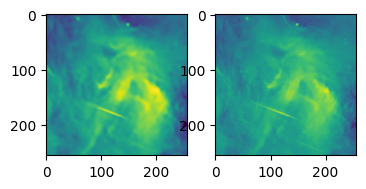

Step 90, Total loss 0.000950


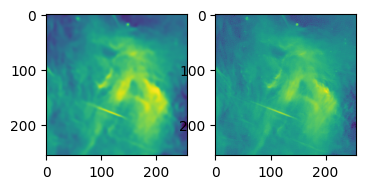

Step 100, Total loss 0.000932


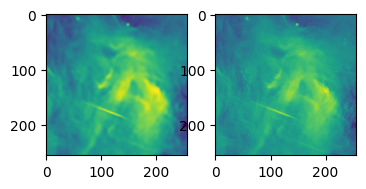

Step 110, Total loss 0.000928


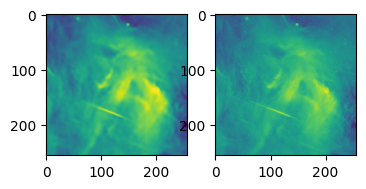

Step 120, Total loss 0.000907


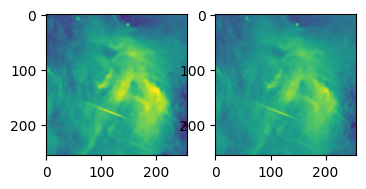

Step 130, Total loss 0.000888


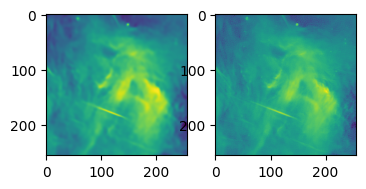

Step 140, Total loss 0.000871


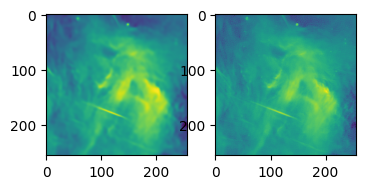

Step 150, Total loss 0.000875


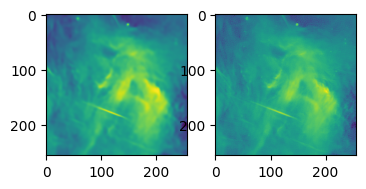

Step 160, Total loss 0.000868


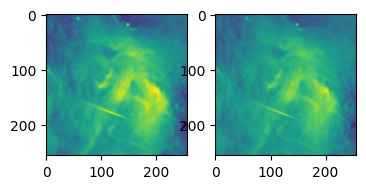

Step 170, Total loss 0.000861


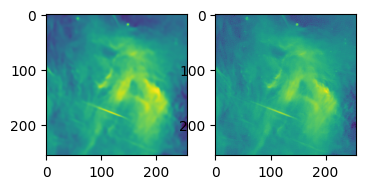

Step 180, Total loss 0.000863


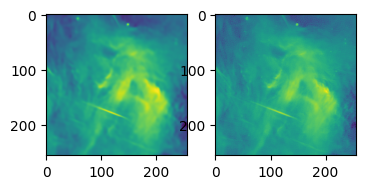

Step 190, Total loss 0.000844


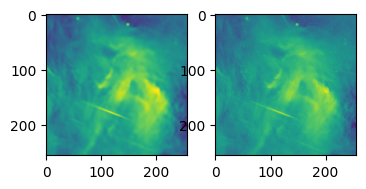

Step 200, Total loss 0.000831


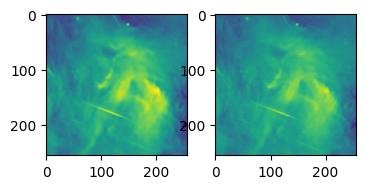

Step 210, Total loss 0.000829


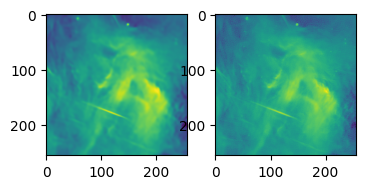

Step 220, Total loss 0.000815


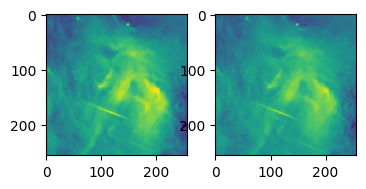

Step 230, Total loss 0.000834


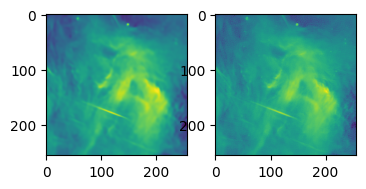

Step 240, Total loss 0.000821


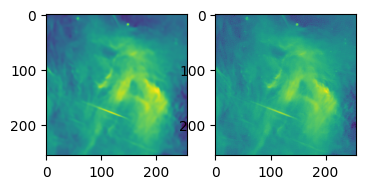

Step 250, Total loss 0.000828


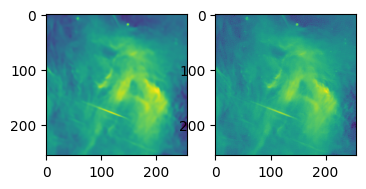

Step 260, Total loss 0.000825


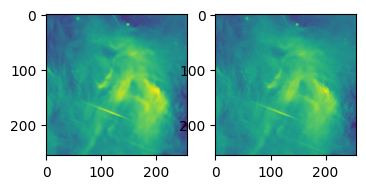

Step 270, Total loss 0.000804


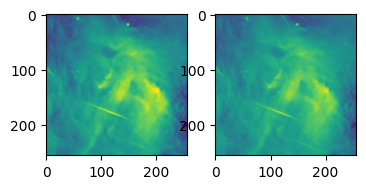

Step 280, Total loss 0.000798


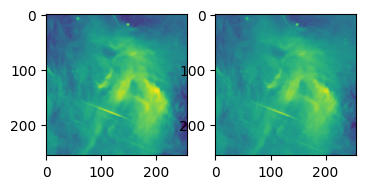

Step 290, Total loss 0.000791


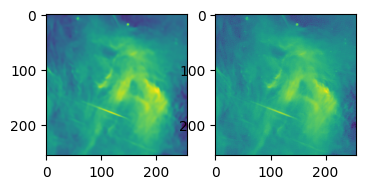

Step 300, Total loss 0.000801


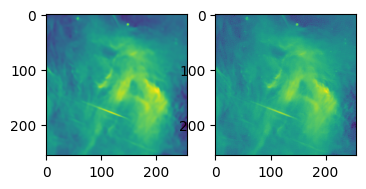

Step 310, Total loss 0.000794


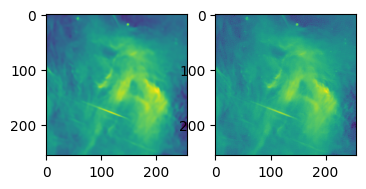

Step 320, Total loss 0.000782


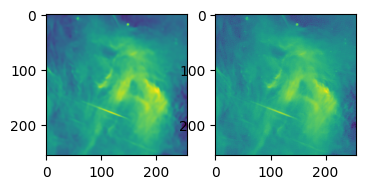

Step 330, Total loss 0.000775


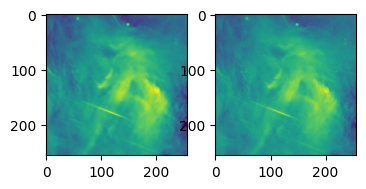

Step 340, Total loss 0.000799


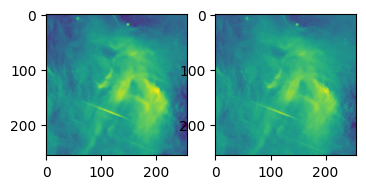

Step 350, Total loss 0.000788


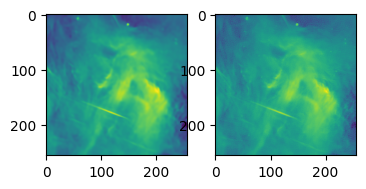

Step 360, Total loss 0.000785


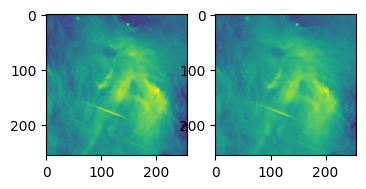

Step 370, Total loss 0.000766


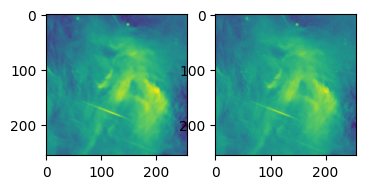

Step 380, Total loss 0.000773


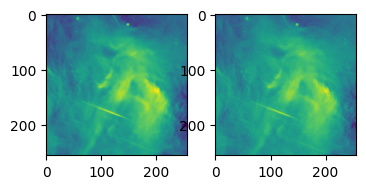

Step 390, Total loss 0.000791


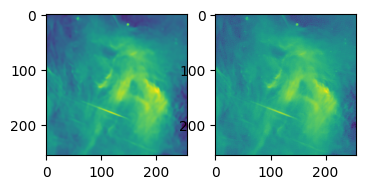

Step 400, Total loss 0.000777


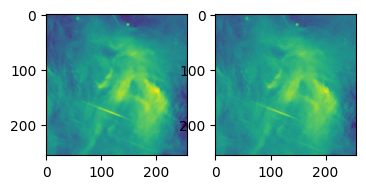

Step 410, Total loss 0.000758


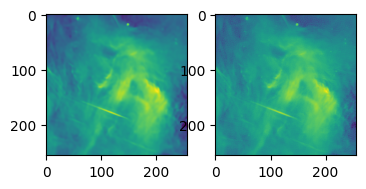

Step 420, Total loss 0.000783


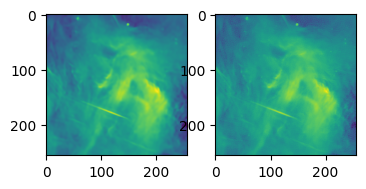

Step 430, Total loss 0.000780


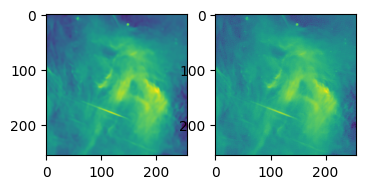

Step 440, Total loss 0.000751


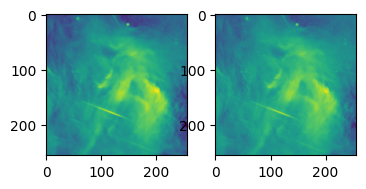

Step 450, Total loss 0.000759


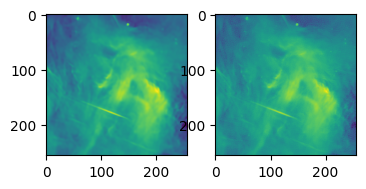

Step 460, Total loss 0.000754


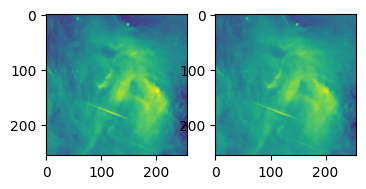

Step 470, Total loss 0.000770


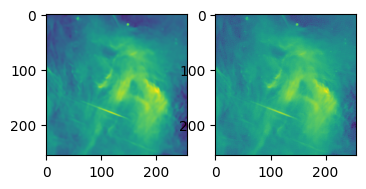

Step 480, Total loss 0.000750


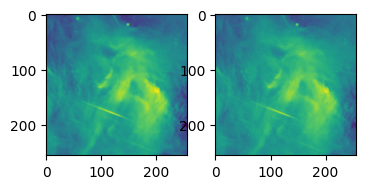

Step 490, Total loss 0.000740


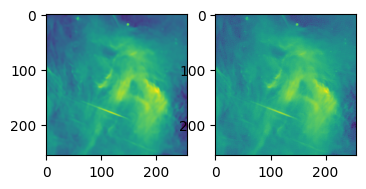

Step 500, Total loss 0.000743


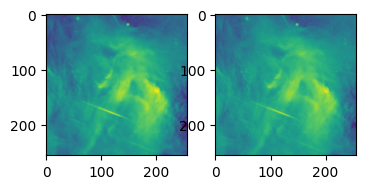

Step 510, Total loss 0.000743


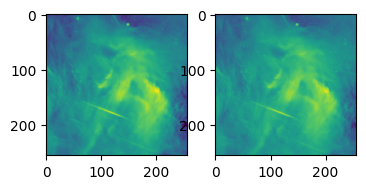

Step 520, Total loss 0.000745


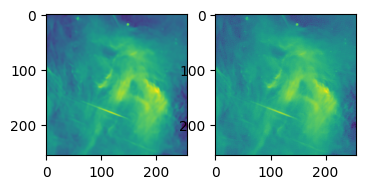

Step 530, Total loss 0.000743


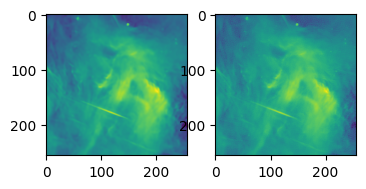

Step 540, Total loss 0.000741


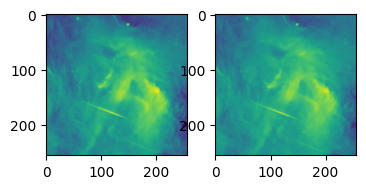

Step 550, Total loss 0.000738


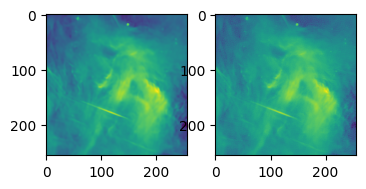

Step 560, Total loss 0.000731


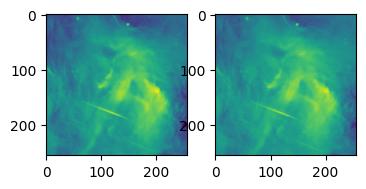

Step 570, Total loss 0.000746


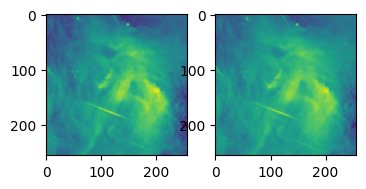

Step 580, Total loss 0.000724


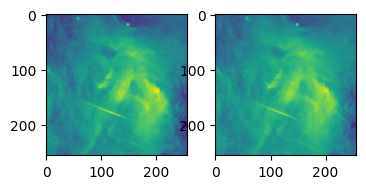

Step 590, Total loss 0.000728


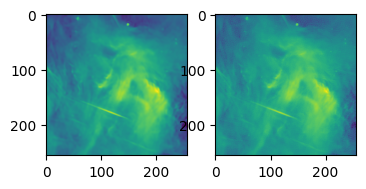

Step 600, Total loss 0.000728


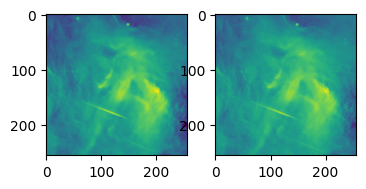

Step 610, Total loss 0.000715


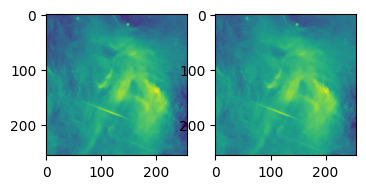

Step 620, Total loss 0.000728


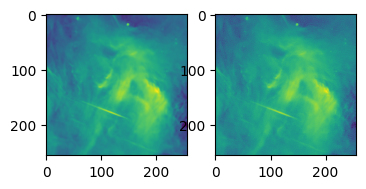

Step 630, Total loss 0.000721


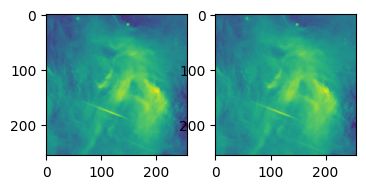

Step 640, Total loss 0.000710


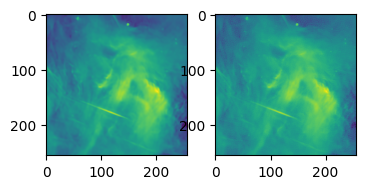

Step 650, Total loss 0.000716


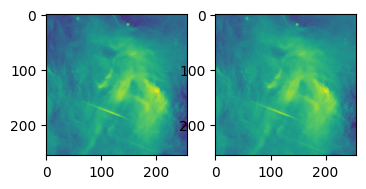

Step 660, Total loss 0.000711


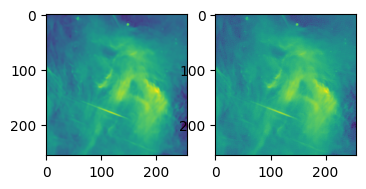

Step 670, Total loss 0.000720


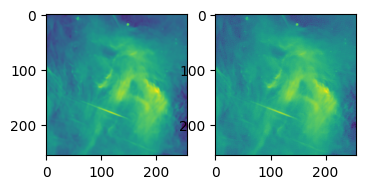

Step 680, Total loss 0.000704


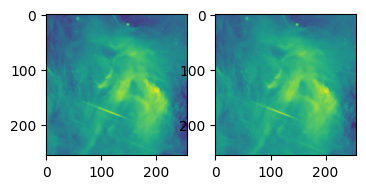

Step 690, Total loss 0.000712


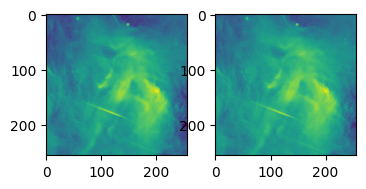

Step 700, Total loss 0.000700


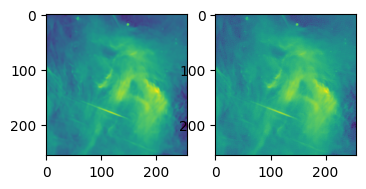

Step 710, Total loss 0.000700


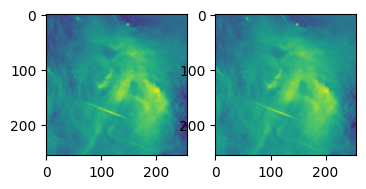

Step 720, Total loss 0.000711


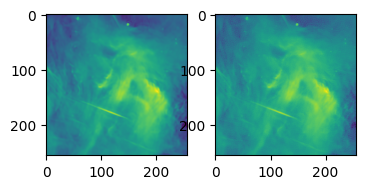

Step 730, Total loss 0.000700


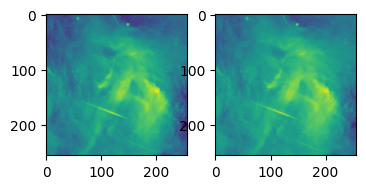

Step 740, Total loss 0.000699


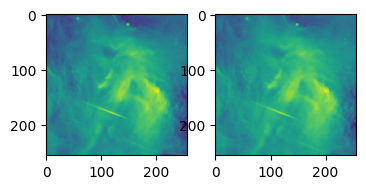

Step 750, Total loss 0.000694


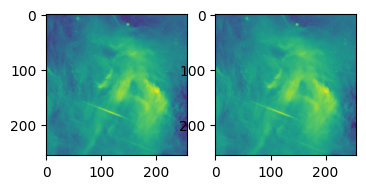

Step 760, Total loss 0.000696


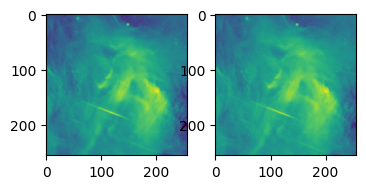

Step 770, Total loss 0.000695


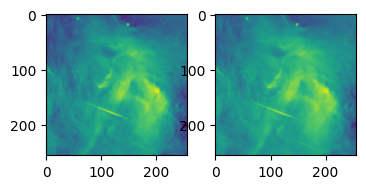

Step 780, Total loss 0.000690


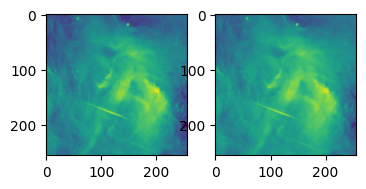

Step 790, Total loss 0.000675


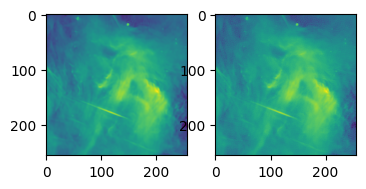

Step 800, Total loss 0.000681


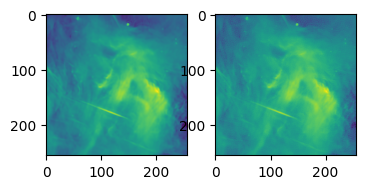

Step 810, Total loss 0.000668


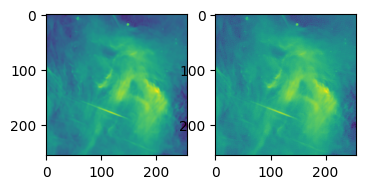

Step 820, Total loss 0.000686


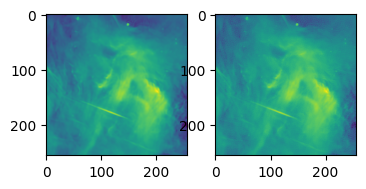

Step 830, Total loss 0.000685


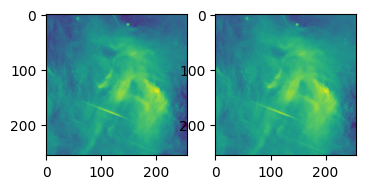

Step 840, Total loss 0.000675


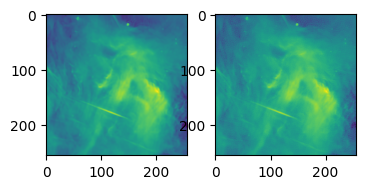

Step 850, Total loss 0.000661


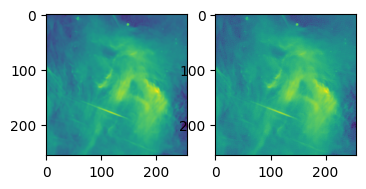

Step 860, Total loss 0.000649


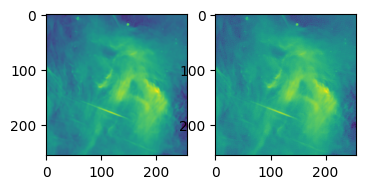

Step 870, Total loss 0.000662


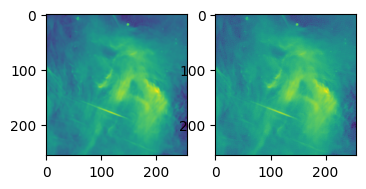

Step 880, Total loss 0.000658


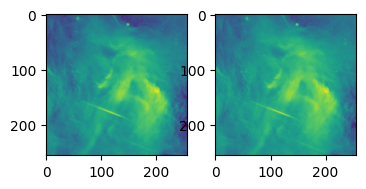

Step 890, Total loss 0.000643


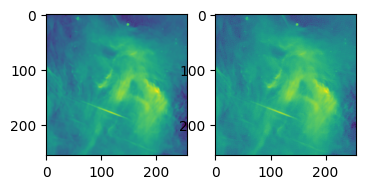

Step 900, Total loss 0.000645


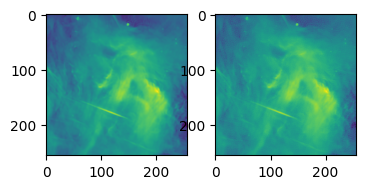

Step 910, Total loss 0.000649


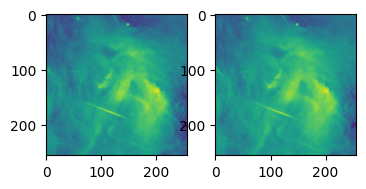

Step 920, Total loss 0.000638


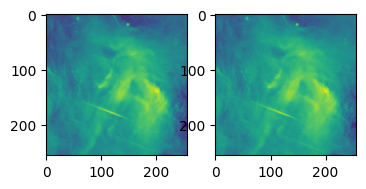

Step 930, Total loss 0.000636


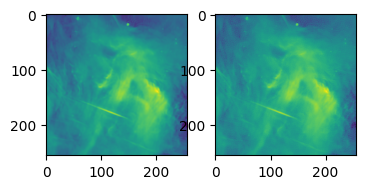

Step 940, Total loss 0.000617


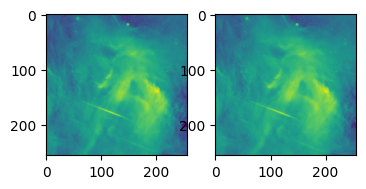

Step 950, Total loss 0.000617


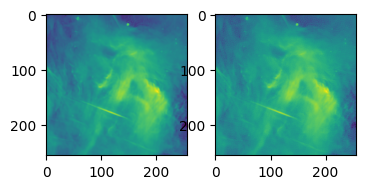

Step 960, Total loss 0.000610


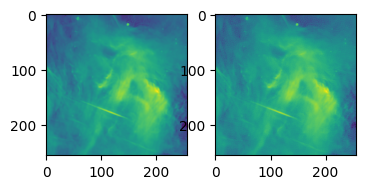

Step 970, Total loss 0.000611


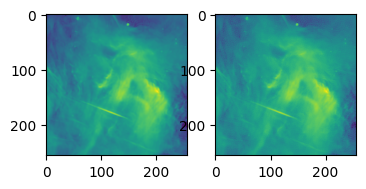

Step 980, Total loss 0.000611


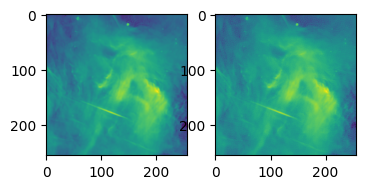

Step 990, Total loss 0.000592


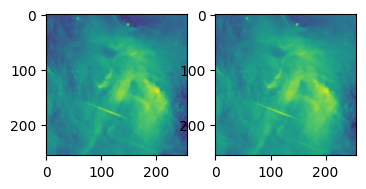

In [112]:
total_steps = 1000 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 10

optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())

#model_input, ground_truth = next(iter(dataloader))
#model_input, ground_truth = model_input.cuda(), ground_truth.cuda()
all_coords    = milkyway.get_coords()
all_pixels    = milkyway.get_pixels()

sparse_sidelength = 256
sparse_coords = milkyway.get_sparse_coords(sparse_sidelength)
sparse_pixels = milkyway.get_sparse_pixels(sparse_coords)
sparse_coords = sparse_coords.cuda()

for step in range(total_steps):
    coords, true_pixels = next(iter(dataloader))
    coords, true_pixels = coords.cuda(), true_pixels.cuda()
    model_output, __ = img_siren(coords)
    loss = ((model_output - true_pixels)**2).mean()

    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))
        fig, axes = plt.subplots(1,2, figsize=(4,2))
        model_output,__ = img_siren(sparse_coords)
        axes[0].imshow( model_output.cpu().view(sparse_sidelength,sparse_sidelength).detach().numpy())
        axes[1].imshow(sparse_pixels.cpu().view(sparse_sidelength,sparse_sidelength).detach().numpy())
        plt.show()

    optim.zero_grad()
    loss.backward()
    optim.step()

grad torch.Size([2048, 1]) torch.Size([2048, 2])
tensor([[-13.1533,   5.2872],
        [ -9.2888,   2.6599],
        [ -5.3723,  -0.7085],
        ...,
        [ -3.3276,   0.1131],
        [ -3.5078,   0.0380],
        [ -3.5488,   0.0830]], device='cuda:0', grad_fn=<MmBackward0>)
div torch.Size([2048, 2]) torch.Size([2048, 2])
grad torch.Size([2048, 1]) torch.Size([2048, 2])
tensor([[ 1.9973,  6.5308],
        [-0.7353, 10.1401],
        [-2.0572, 11.6312],
        ...,
        [ 0.2147,  0.0672],
        [ 0.3579,  0.1156],
        [ 0.4262,  0.1882]], device='cuda:0', grad_fn=<MmBackward0>)
div torch.Size([2048, 2]) torch.Size([2048, 2])
grad torch.Size([2048, 1]) torch.Size([2048, 2])
tensor([[ 6.3489,  0.6012],
        [ 6.2907,  1.3256],
        [ 5.3144,  2.9112],
        ...,
        [-0.1005,  0.3259],
        [-0.2194,  0.2849],
        [-0.2496,  0.3011]], device='cuda:0', grad_fn=<MmBackward0>)
div torch.Size([2048, 2]) torch.Size([2048, 2])
grad torch.Size([2048, 1]) torc

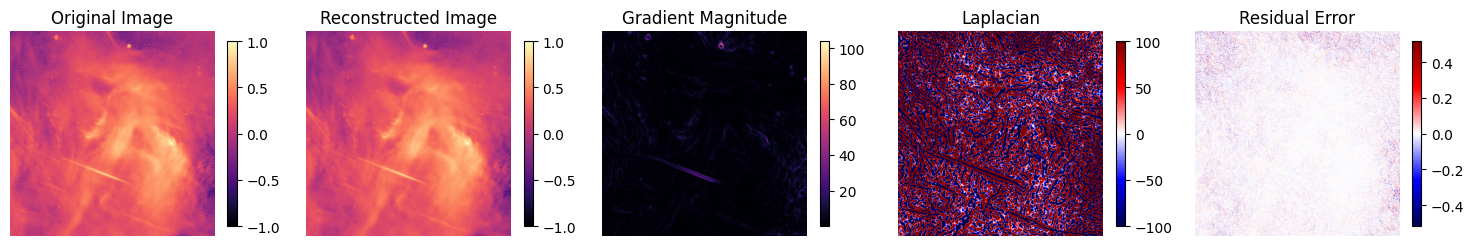

In [114]:
# Visualization after training
import matplotlib.colors as colors

# Initialize tensors to store the full reconstructed image, gradients, and Laplacian
full_model_output   = torch.empty_like(all_pixels)
full_grad_output    = torch.zeros(all_pixels.shape[0],  2, device=all_pixels.device)
full_laplace_output = torch.empty_like(all_pixels)

# Define a smaller batch size for gradient/laplacian visualization to prevent OOM
batch_size_pixels_viz = 2048 # Reduced batch size for visualization of gradients/laplacian
num_batches_viz = (milkyway.N_total_pixels + batch_size_pixels_viz - 1) // batch_size_pixels_viz

# Process the full image in batches for visualization
for i in range(num_batches_viz):
    start_idx_viz = i * batch_size_pixels_viz
    end_idx_viz = min((i + 1) * batch_size_pixels_viz, milkyway.N_total_pixels)

    # Siren's forward method internally creates a tensor with requires_grad=True
    # We need to capture this internal tensor for calculating gradients and Laplacian.
    batch_input_coords = all_coords[ start_idx_viz:end_idx_viz,:].cuda().float().clone().detach().requires_grad_(True)
    model_output,model_coords = img_siren(batch_input_coords) # Get the internal coords from Siren

    # Calculate gradients and Laplacian
    img_grad = torch.autograd.grad(model_output, model_coords, grad_outputs=torch.ones_like(batch_output), create_graph=True,allow_unused=True)[0]
    img_laplacian = laplace(model_output, model_coords)

    # Store results in the full tensors
    full_model_output[  start_idx_viz:end_idx_viz, :] = model_output.detach()
    full_grad_output[    start_idx_viz:end_idx_viz, :] = img_grad.detach()
    full_laplace_output[start_idx_viz:end_idx_viz, :] = img_laplacian.detach()

# Plot the results
fig, axes = plt.subplots(1,5, figsize=(15,4)) # Adjusted figsize for better viewing

# Shared colour scale for original & reconstructed
vmin = all_pixels.min().item()
vmax = all_pixels.max().item()

# Original Image
c0 = axes[0].imshow(
    all_pixels.cpu().view(sidelength, sidelength).detach().numpy(),
    cmap='magma',
    vmin=vmin,
    vmax=vmax
)
axes[0].set_title("Original Image")
axes[0].axis('off') # Hide axes for cleaner image display


# Reconstructed Image
c1 = axes[1].imshow(
    full_model_output.cpu().view(sidelength, sidelength).detach().numpy(),
    cmap='magma',
    vmin=vmin,
    vmax=vmax
)
axes[1].set_title("Reconstructed Image")
axes[1].axis('off') # Hide axes for cleaner image display

# Gradient Magnitude
# Normalize gradient magnitude for better visualization, if needed
grad_magnitude = full_grad_output.norm(dim=-1).cpu().view(sidelength, sidelength).detach().numpy()
c2 = axes[2].imshow(grad_magnitude, cmap='magma') # Using a different colormap for gradients
axes[2].set_title("Gradient Magnitude")
axes[2].axis('off')

# Laplacian
# Normalize Laplacian for better visualization, if needed
laplacian_output = full_laplace_output.cpu().view(sidelength, sidelength).detach().numpy()
c3 = axes[3].imshow(laplacian_output, cmap='seismic',norm=colors.CenteredNorm(halfrange=100)) # Centered colormap for Laplacian
axes[3].set_title("Laplacian")
axes[3].axis('off')

# Residuals
residual = (all_pixels-full_model_output).cpu().view(sidelength, sidelength).detach().numpy()
c4 = axes[4].imshow(residual, cmap='seismic',norm=colors.CenteredNorm()) # Centered colormap for Laplacian
axes[4].set_title("Residual Error")
axes[4].axis('off')

plt.colorbar(c0, ax=axes[0],shrink=0.5)
plt.colorbar(c1, ax=axes[1],shrink=0.5)
plt.colorbar(c2, ax=axes[2],shrink=0.5)
plt.colorbar(c3, ax=axes[3],shrink=0.5)
plt.colorbar(c4, ax=axes[4],shrink=0.5)

plt.tight_layout() # Adjust subplot parameters for a tight layout
plt.show()